<a href="https://colab.research.google.com/github/TheRadDani/Summarization-with-Transformers/blob/main/Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import pipeline, set_seed

In [ ]:
!pip install datasets

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
print(f"Features: {dataset['train'].column_names}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Features: ['article', 'highlights', 'id']


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [ ]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt") #model for tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
string = "the dog is climbing the three"

In [ ]:
sent_tokenize(string)

['the dog is climbing the three']

In [ ]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries["baseline"] = three_sentence_summary(sample_text)

In [ ]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'}

In [ ]:
from transformers import pipeline, set_seed

set_seed(69)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

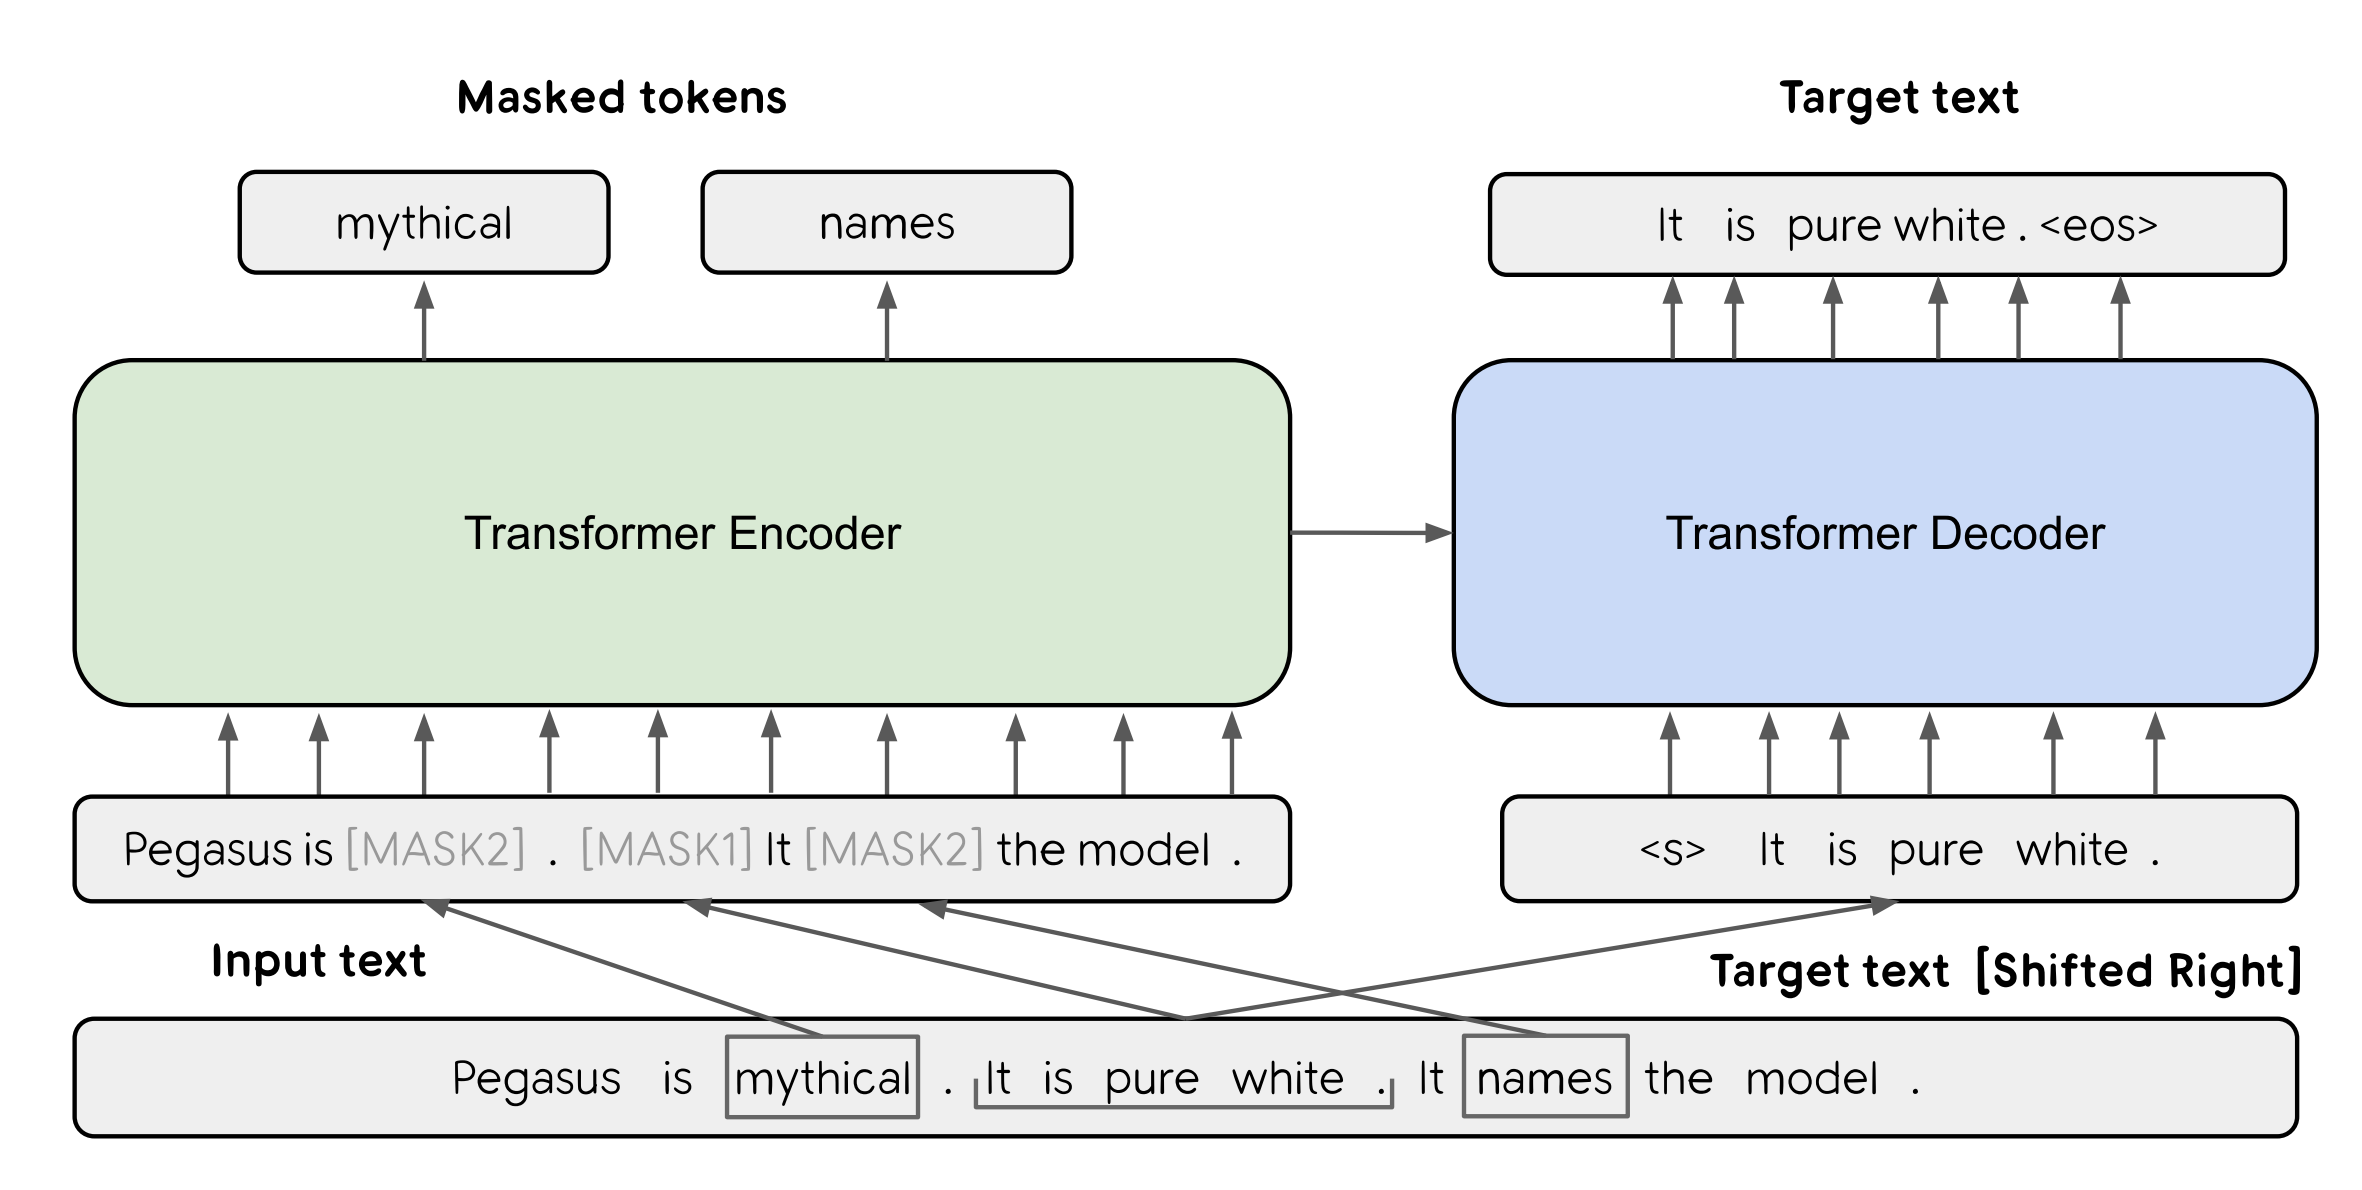

In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .", ".\n")

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
The mentally ill are being housed in "outdated" housing -- like many other jails across the country -- that makes it hard for them to get the help they need.
According to many mental health experts, this means that the

Measuring the Quality of Generated Text

BLEU

In [ ]:
!pip install sacrebleu

In [ ]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu",trust_remote_code=True)

In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [ ]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


ROUGE

In [ ]:
!pip install rouge_score

In [ ]:
rouge_metric = load_metric("rouge",trust_remote_code=True)

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.166667,0.018868,0.111111,0.166667
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.316832,0.202020,0.277228,0.316832


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

rouge_metric = load_metric("rouge", cache_dir=None, trust_remote_code=True)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [ ]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.38912,0.171285,0.245153,0.354079


In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [24:31<00:00, 11.77s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.012385,0.000524,0.01227,0.01235


In [ ]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
<n>Hannah: I'd rather you texted him.
<n>Amanda: Just text him.



In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [18:11<00:00, 10.60s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015551,0.000302,0.015586,0.015561


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


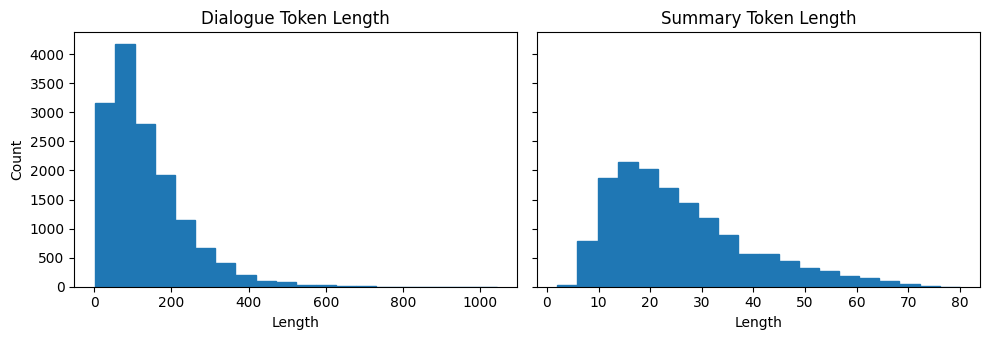

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`